# Data Engineering Assignment

The following Python codes is an ELT pipeline that extract data from API, load into a json/CSV file and finally transformed for usage. The csv can be ingested into hadoop HDFS and creating external table to read them, however in this assignment i will store it as a simple CSV and the codes will run the data in a dataframe to produce the results.

The ELT pipeline follows the basic structure below:
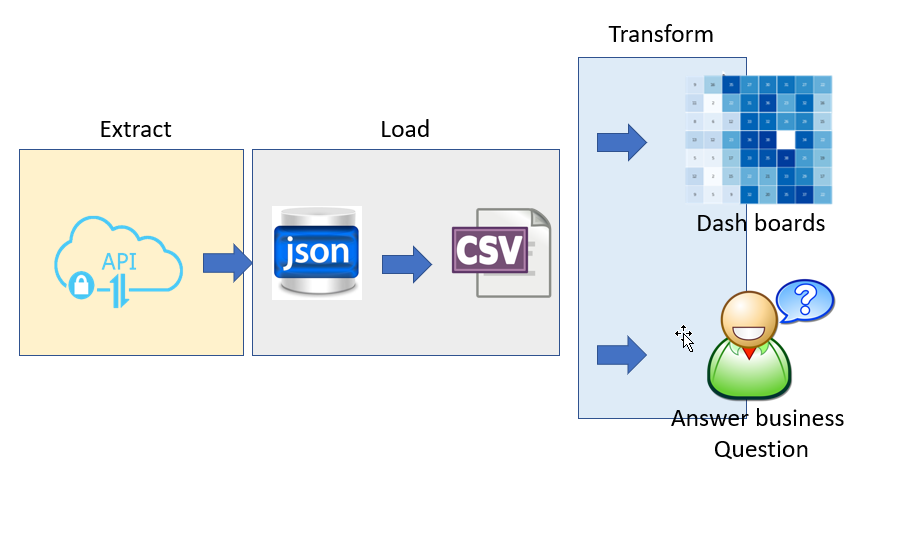


# Download PyGithub request & import libraries

In [1]:
#pip install PyGithub requests
from github import Github
import os
import requests
import datetime
import json
import requests
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
import seaborn as sns
import matplotlib.pyplot as plt

# Run this cell to enter from date and to date

In [2]:
while True:
    from_date = input ("Enter from date YYYY-MM-DD :") 
    from_date = from_date + ' 00:00:00.000000'
    try:
        date_time_obj_from = datetime.datetime.strptime(from_date,'%Y-%m-%d %H:%M:%S.%f')
        break
    except:
        print('Please enter a valid date --> YYYY-MM-DD')
        
while True:
    to_date = input ("Enter to date YYYY-MM-DD :") 
    to_date = to_date + ' 00:00:00.000000'
    try:
        date_time_obj_to = datetime.datetime.strptime(to_date,'%Y-%m-%d %H:%M:%S.%f')
        break
    except:
        print('Please enter a valid date --> YYYY-MM-DD')
        

print('To extract git commits from date:' +  str(date_time_obj_from) + ' to '+ str(date_time_obj_to))

Enter from date YYYY-MM-DD :2020-01-01
Enter to date YYYY-MM-DD :2020-09-01
Extracting git commits from date:2020-01-01 00:00:00 to 2020-09-01 00:00:00


# Extract Load and transform
Might take awhile....

In [3]:
# Access token and configuration. Can be stored as a config file in enviornments
github_api = 'https://api.github.com'
owner = 'apache'
#access_token = 'a1ce157932be2ac00255ee6dea9770969879e965'
access_token = '1bcc1714ce6ed35f6e5e79f2896bf27148cb90de'
headers = {'Authorization':"Token "+access_token}
repo = "airflow"
# Request for Session
gh_session = requests.Session()

#Functions to loop thru git repo of 100 page until current
def commits_of_repo_github(repo, owner, api):
    commits = []
    next = True
    i = 1
    while next == True:
        url = github_api + '/repos/{}/{}/commits?page={}&per_page=100'.format(owner, repo, i)
        commit_pg = gh_session.get(url = url, headers=headers)
        commit_pg_list = [dict(item, **{'repo_name':'{}'.format(repo)}) for item in commit_pg.json()]    
        commit_pg_list = [dict(item, **{'owner':'{}'.format(owner)}) for item in commit_pg_list]
        commits = commits + commit_pg_list
        if 'Link' in commit_pg.headers:
            if 'rel="next"' not in commit_pg.headers['Link']:
                next = False
        i = i + 1
    return commits

def create_commits_df(repo, owner, api):
    commits_list = commits_of_repo_github(repo, owner, api)
    return json_normalize(commits_list)

# put commits in CSV
commits = create_commits_df('airflow', 'apache', github_api)
# Only Use needed columns
allcommits=commits[['commit.author.date','commit.author.email','commit.author.name']]
# Convert date columns and filter from and to date
allcommits['commit.author.date'] = allcommits['commit.author.date'].astype('datetime64[ns]')
allcommits = allcommits[(allcommits['commit.author.date'] > date_time_obj_from) & (allcommits['commit.author.date'] < date_time_obj_to)]
# Transformation for Longest commit streak
allcommits =  allcommits.sort_values(by=['commit.author.date'])
allcommits.reset_index(inplace=True,drop=True)
allcommits['match'] = allcommits['commit.author.email'] == allcommits['commit.author.email'].shift()
allcommits['match3']=0.0
max=0.0
# Check if above is true and add one if true
for index, row in allcommits.iterrows():
    if row['match']==True:
        max = max + 1
        allcommits.loc[index,'match3'] = max
    else:
        allcommits.loc[index,'match3'] = 1
        max =0.0
        
# Transformation to bin commit hours      
allcommits['day']=allcommits['commit.author.date'].dt.day_name()
allcommits['date.hour']=allcommits['commit.author.date'].dt.hour
pcondition = [(allcommits['date.hour']>=0) & (allcommits['date.hour']<3),
              (allcommits['date.hour']>=3) & (allcommits['date.hour']<6),
              (allcommits['date.hour']>=6) & (allcommits['date.hour']<9),
              (allcommits['date.hour']>=9) & (allcommits['date.hour']<12),
              (allcommits['date.hour']>=12) & (allcommits['date.hour']<15),
              (allcommits['date.hour']>=15) & (allcommits['date.hour']<18),
              (allcommits['date.hour']>=18) & (allcommits['date.hour']<21),
              (allcommits['date.hour']>=21) & (allcommits['date.hour']<24)
             ]
pvalues = ['00 - 03',
           '03 - 06',
           '06 - 09',
           '09 - 12',
           '12 - 15',
           '15 - 18',
           '18 - 21',
           '21 - 00',
          ]
allcommits['hour.bin'] = np.select(pcondition,pvalues)

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Top 5 Commiters

In [4]:
#Top 5 committers
allcommits.groupby(['commit.author.email'])['commit.author.email'].value_counts().nlargest(5)

commit.author.email               commit.author.email             
kaxilnaik@gmail.com               kaxilnaik@gmail.com                 394
jarek.potiuk@polidea.com          jarek.potiuk@polidea.com            346
mik-laj@users.noreply.github.com  mik-laj@users.noreply.github.com    317
ash_github@firemirror.com         ash_github@firemirror.com            90
turbaszek@gmail.com               turbaszek@gmail.com                  82
Name: commit.author.email, dtype: int64

# Top Commit Streak

In [5]:
# Top commiting streak
allcommits.sort_values(by=['match3'],ascending=False).head(1)

,commit.author.date,commit.author.email,commit.author.name,match,match3,day,date.hour,hour.bin
671,2020-03-23 04:58:08,kaxilnaik@gmail.com,Kaxil Naik,True,14.0,Monday,4,03 - 06


# Heat Map

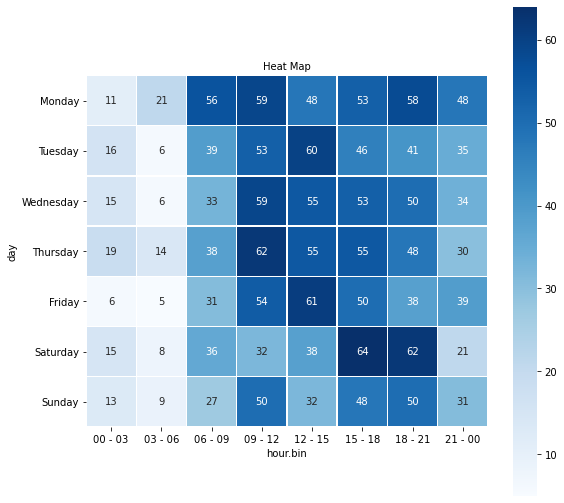

In [6]:
heatmap = allcommits[['day','hour.bin','commit.author.email']].groupby(['day', 'hour.bin']).size().reset_index(name='counts')
test = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
day_type = CategoricalDtype(categories=test, ordered =True)
heatmap['day'] = heatmap['day'].astype(day_type)
heatmap = heatmap.sort_values(['day', 'hour.bin'])
heatmap = heatmap.pivot(index='day', columns='hour.bin',values='counts')
plt.figure(figsize =(9,9))
plt.xlabel('3 hour bin', size=10)
plt.ylabel('day', size=10)
plt.title('Heat Map', size=10)
sns.heatmap(heatmap, annot=True, fmt="", linewidth=0.5, square=True, cmap='Blues')